In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras import mixed_precision

from mbptycho.code.simulation import reloadSimulation
from skimage.feature import register_translation
from scipy import io
from mbptycho.code.recons.recons import DisplacementFullModelReconstruction
import copy
import os
base_path = os.environ['HOME']

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.set_visible_devices(gpus[2], 'GPU')
tf.config.experimental.set_memory_growth(gpus[2], True)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

2024-02-20 00:02:06.435604: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!pwd

/gpfs/fs1/home/skandel/code/mbptycho/mbptycho/tests/point_inclusions_sparse_scan/weak_peaks


In [4]:
strain_type = 'point_inclusion'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/weak_peaks/'
sim_data_path = f'{data_path}/sim_{strain_type}.lz4'
sample_data_path = f'{data_path}/sample_{strain_type}.lz4'

save_plots = False

In [5]:
sm = reloadSimulation(sim_data_path, reload_sim=True)#sim_params={"HKL_list":[[1, 2, 0]]}
#sm.sample.Ux_trunc.shape, sm.sample.params.sample_pix_size

File exists. Reloading...


## Directly reconstructing the displacements

In [6]:
recons = DisplacementFullModelReconstruction(simulation=sm, shared_magnitudes=True)

2024-02-20 00:03:02.847619: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38178 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:b7:00.0, compute capability: 8.0


Setting background_level to 1e-08...


2024-02-20 00:03:04.422994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [324]
	 [[{{node Placeholder/_0}}]]
2024-02-20 00:03:04.423252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [324]
	 [[{{node Placeholder/_0}}]]


In [7]:
disp_lr = 1e-2
magnitude_lr = 1e-1
if not 'ux_uy_2d_v' in recons.optimizers:
    recons.setDisplacementAdamOptimizer(disp_lr)
else:
    recons.optimizers['ux_uy_2d_v']['learning_rate'].assign(disp_lr)

if not 'magnitudes_log_v' in recons.optimizers:
    recons.setMagnitudeLogAdamOptimizer(magnitude_lr)
else:
    recons.optimizers['magnitudes_log_v']['learning_rate'].assign(magnitude_lr)

recons.optimizers

{'ux_uy_2d_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.01>,
  'optimizer': <keras.mixed_precision.loss_scale_optimizer.LossScaleOptimizerV3 at 0x150b31e56130>,
  'var': <tf.Variable 'ux_uy:0' shape=(18050,) dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>},
 'magnitudes_log_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>,
  'optimizer': <keras.mixed_precision.loss_scale_optimizer.LossScaleOptimizerV3 at 0x150b31e9db50>,
  'var': <tf.Variable 'magnitudes_log_v:0' shape=(9028,) dtype=float32, numpy=
  array([-16.118095, -16.118095, -16.118095, ...,   0.      ,   0.      ,
           0.      ], dtype=float32)>}}

In [8]:
recons.minimize(1000, debug_output_epoch_frequency=10)

Initializing the datalog...


2024-02-20 00:03:08.786912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'iters_before_registration' with dtype int32
	 [[{{node iters_before_registration}}]]


Instructions for updating:
Use fn_output_signature instead


2024-02-20 00:03:19.143202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'iters_before_registration' with dtype int32
	 [[{{node iters_before_registration}}]]
2024-02-20 00:03:37.725491: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x150294004020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-20 00:03:37.725530: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-02-20 00:03:37.731916: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-20 00:03:37.754208: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
202

        epoch  train_loss     err_ux     err_uy  err_ux_film  err_uy_film   err_rho0   err_rho1   err_rho2   err_rho3  err_rho_film0  err_rho_film1  err_rho_film2  err_rho_film3
60         10    2.08e+07      0.824      0.796        0.736        0.754      0.875      0.715      0.802      0.947          0.846          0.692          0.775          0.934
120         20   2.27e+07      0.794      0.791       0.67      0.715      0.855       0.59      0.716      0.931      0.814      0.567      0.702      0.915
180         30   1.71e+07      0.795      0.781      0.678      0.704      0.846      0.531      0.697      0.902      0.789      0.501      0.681      0.889
240         40   2.71e+07      0.807      0.767      0.692      0.692      0.857      0.508      0.679      0.879       0.79      0.477      0.661      0.876
300         50   1.72e+07       0.82      0.754      0.708      0.679       0.84      0.495      0.659      0.861      0.803      0.465      0.639      0.862
360         

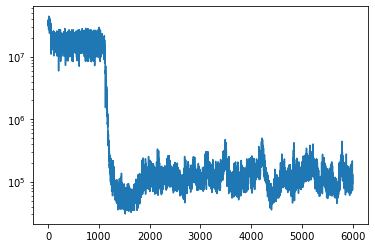

In [9]:
plt.plot(recons.datalog.dataframe.train_loss.dropna())
plt.yscale('log')

In [10]:

true_items = {}
recons_items = {}

if recons._model_type != 'phase':
    recons_items[r"$\alpha_x$"] = recons.ux_2d - recons.ux_2d.mean() 
    true_items[r"$\alpha_x$"] = recons._ux_true - recons._ux_true.mean() 

    recons_items[r"$\alpha_y$"] = recons.uy_2d - recons.uy_2d.mean()
    true_items[r"$\alpha_y$"] = recons._uy_true - recons._uy_true.mean()


if not recons._model_type == 'displacement_to_phase':

    for i in range(recons.rho_2d.shape[0]):
        phase_label = ''.join(sm.params.HKL_list[i].astype('str'))
        labelstr = rf"$\phi$({phase_label})"
        
        rollr, errr, phaser = register_translation( recons._rho_true[i], recons.rho_2d[i], upsample_factor=10)
        recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        true_items[labelstr] = np.angle(recons._rho_true[i])

/home/skandel/.conda/envs/tf2/lib/python3.9/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
/home/skandel/.conda/envs/tf2/lib/python3.9/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
/home/skandel/.conda/envs/tf2/lib/python3.9/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
/home/skandel/.conda/envs/tf2/lib/python3.9/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is 

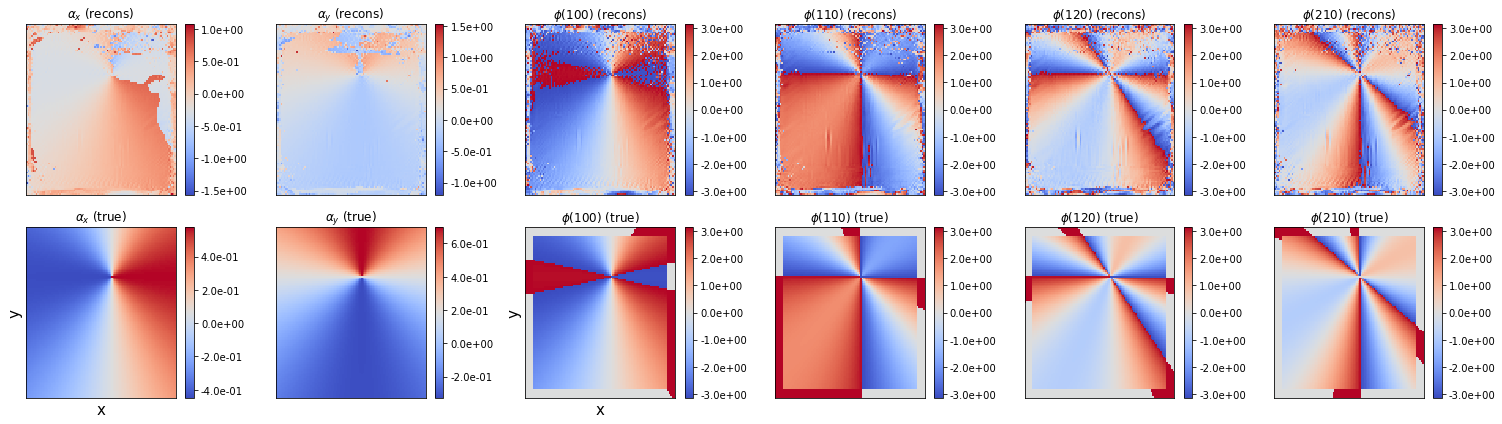

In [11]:
save_plots = False
if recons._model_type == 'phase':
    subplots_x = recons.rho_2d.shape[0] 
    figsize_x = subplots_x * 3.5
elif recons._model_type == 'displacement_to_phase':
    figsize_x = 8
    subplots_x = 2
else:
    subplots_x = (recons.rho_2d.shape[0] + 2) 
    figsize_x = subplots_x * 3.5

recons_suffix = recons._model_type

    
fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 
for i, (key, value) in enumerate(recons_items.items()):
    if i == 0 and recons._model_type != 'phase':
        vmin=-2.1
        vmax = 2.1
    elif i == 1 and recons._model_type!= 'phase':
        vmin = -0.21
        vmax = 0.21
    else:
        vmin = -np.pi
        vmax = np.pi
    
    #value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp0 = axs[0, i].pcolormesh(value, cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[0, i].set_title(key + " (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%2.1e")
    
    true_value = true_items[key] 
    #true_value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp1 = axs[1, i].pcolormesh(true_items[key], cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[1, i].set_title(key + " (true)")
    plt.colorbar(cp1, ax=axs[1, i], format="%2.1e")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

if not recons._model_type=='displacement_to_phase':
    axs[1,2].set_xlabel('x', fontsize=15)
    axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()

if save_plots:
    
    plt.savefig(f'{data_path}_recons_{recons_suffix}.png', bbox_inches='tight')
plt.show()

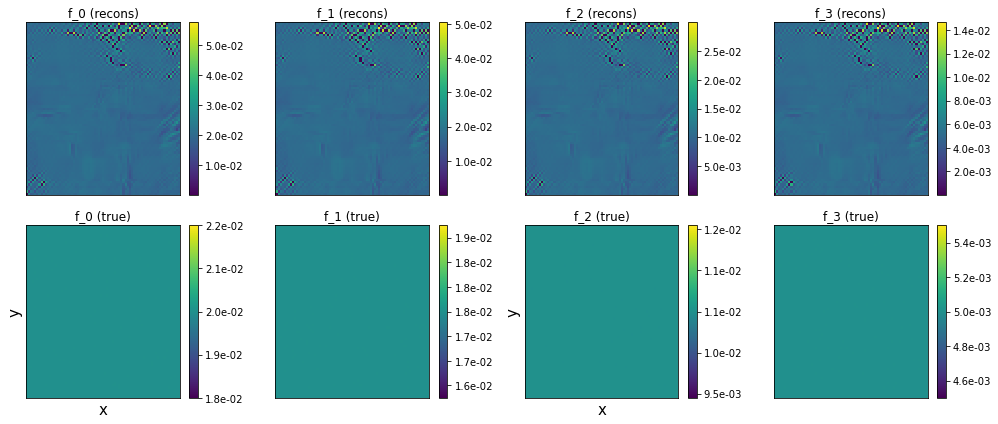

In [12]:
subplots_x = recons.rho_2d.shape[0] 
figsize_x = subplots_x * 3.5

fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 

for i in range(recons.rho_2d.shape[0]):
    recons_amplitudes = np.abs(recons.rho_2d[i][10:-10,10:-10])
    true_amplitudes = np.abs(recons._rho_true[i][10:-10,10:-10])
    
    cp0 = axs[0, i].pcolormesh(recons_amplitudes)
    axs[0, i].set_title(f"f_{i} (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%.1e")
    
    cp1 = axs[1, i].pcolormesh(true_amplitudes)
    axs[1, i].set_title(f"f_{i} (true)")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    plt.colorbar(cp1, ax=axs[1, i], format="%.1e")
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

axs[1,2].set_xlabel('x', fontsize=15)
axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}_recons_amplitudes.png', bbox_inches='tight')
plt.show()


In [13]:
recons.saveOutputsAndLog(data_path, prefix='direct_no_projection_')